# **Exploração de dados com Apache Spark**
 Conjunto de dados no formato CSV.
 
 1.   Dataset 1: Investidores do Tesouro direto - https://dados.gov.br/dataset/investidores-do-tesouro-direto/
 2.   Dataset 2: Operações no tesouro direto - https://dados.gov.br/dataset/operacoes-do-tesouro-direto/
  


## **Importação da configuração inicial e bibliotecas**

In [1]:
from ipynb.fs.full.conf_spark import *
from ipynb.fs.full.explorer_utils import *
import pandas as pd
import pyspark.sql.functions as Func
from pyspark.sql.functions import *
from pyspark.sql.types import *


## **Inicialização de novas instancias do Spark**

In [2]:
spark_settings = SettingsSpark(instance="4", executor_memory="512m")
spark_settings.init_minio()
spark = spark_settings.builder_conf()

## **Carregamento dos arquivos no formato CSV**

In [ ]:
df_operacoes = spark.read.csv("s3a://bronze/OperacoesTesouroDireto.csv", sep=';', inferSchema=True, header=True)

In [ ]:
df_investidores = spark.read.csv("s3a://bronze/InvestidoresTesouroDireto.csv", sep=';', inferSchema=True, header=True, encoding="ISO-8859-1")

In [5]:
df_operacoes.printSchema()
df_operacoes.show(10)

In [6]:
df_investidores.printSchema()
df_investidores.show(10)

## **Limpeza,normalização, correção das colunas do data frame operações**

In [7]:
df_operacoes_rename= df_operacoes.withColumnRenamed("Codigo do Investidor","investidor") \
        .withColumnRenamed("Data da Operacao","dt_operacao") \
        .withColumnRenamed("Tipo Titulo","tipo") \
        .withColumnRenamed("Vencimento do Titulo","dt_vencimento") \
        .withColumnRenamed("Quantidade","qtd") \
        .withColumnRenamed("Valor do Titulo","vlr_titulo") \
        .withColumnRenamed("Valor da Operacao","vlr_operacao") \
        .withColumnRenamed("Tipo da Operacao","tipo_operacao") \
        .withColumnRenamed("Canal da Operacao", "canal_operacao") 
    
df_operacoes_rename.show(10)

## **Limpeza,normalização, correção das colunas do data frame investidores**

In [8]:
df_investidores_rename= df_investidores.withColumnRenamed("Codigo do Investidor","investidor") \
        .withColumnRenamed("Data de Adesao","dt_adesao") \
        .withColumnRenamed("Estado Civil","estado_civil") \
        .withColumnRenamed("Genero","genero") \
        .withColumnRenamed("Profissao","profissao") \
        .withColumnRenamed("Idade","idade") \
        .withColumnRenamed("UF do Investidor","uf") \
        .withColumnRenamed("Cidade do Investidor","cidade") \
        .withColumnRenamed("Situacao da Conta", "situacao_conta") \
        .withColumnRenamed("Operou 12 Meses", "operou") \
        .drop("Pais do Investidor") 
    
df_investidores_rename.show(10, truncate=False)

## **Gravação dos dados, no datalake no formato parquet**

In [9]:
df_operacoes_rename.write.parquet("s3a://silver/OperacoesTesouroDireto.parquet", mode="overwrite")

In [10]:
df_investidores_rename.write.parquet("s3a://silver/InvestidoresTesouroDireto.parquet", mode="overwrite")

## **Limpeza e liberação da memória, finalização das instancias do Spark**

In [ ]:
spark_settings.stop()

In [3]:
spark_settings = SettingsSpark(instance="4", executor_memory="512m")
spark_settings.init_minio()
spark = spark_settings.builder_conf()

## **Carregamento dos dados no formato parquet**

In [89]:
custom_schema = StructType([ \
                            StructField("investidor",IntegerType(),True), \
                            StructField("dt_operacao",StringType(),True), \
                            StructField("tipo",StringType(),True), \
                            StructField("dt_vencimento",StringType(),True), \
                            StructField("qtd",FloatType(),True), \
                            StructField("vlr_titulo",DecimalType(),True), \
                            StructField("vlr_operacao",DecimalType(),True), \
                            StructField("tipo_operacao",StringType(),True), \
                            StructField("canal_operacao",StringType(),True), \
  ])


In [5]:
df_ope = spark.read.parquet("s3a://silver/OperacoesTesouroDireto.parquet", inferSchema=True, header=True)
df_ope.printSchema()

root
 |-- investidor: integer (nullable = true)
 |-- dt_operacao: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- dt_vencimento: string (nullable = true)
 |-- qtd: string (nullable = true)
 |-- vlr_titulo: string (nullable = true)
 |-- vlr_operacao: string (nullable = true)
 |-- tipo_operacao: string (nullable = true)
 |-- canal_operacao: string (nullable = true)



## **Troca da virgula pelo ponto e conversão do atributo para float**

In [6]:
df_ope = ( 
            df_ope
              .withColumn('qtd', regexp_replace('qtd', ',', '.').cast('float'))
              .withColumn('vlr_titulo', regexp_replace('vlr_titulo', ',', '.').cast('float'))
              .withColumn('vlr_operacao', regexp_replace('vlr_operacao', ',', '.').cast('float'))
        )
df_ope.show()

+----------+-----------+--------------------+-------------+----+----------+------------+-------------+--------------+
|investidor|dt_operacao|                tipo|dt_vencimento| qtd|vlr_titulo|vlr_operacao|tipo_operacao|canal_operacao|
+----------+-----------+--------------------+-------------+----+----------+------------+-------------+--------------+
|    337243| 31/07/2014|Tesouro Prefixado...|   01/01/2025| 3.0|    904.65|     2713.95|            V|             H|
|    337243| 31/07/2014|Tesouro Prefixado...|   01/01/2021| 4.0|     935.7|      3742.8|            V|             H|
|    337243| 31/07/2014|Tesouro Prefixado...|   01/01/2017|37.0|    978.59|    36207.83|            V|             H|
|    337289| 16/07/2014|       Tesouro IPCA+|   15/08/2024| 0.2|   1358.36|      271.67|            C|             S|
|    338382| 31/07/2014|   Tesouro Prefixado|   01/01/2017| 5.1|    770.03|     3927.15|            C|             H|
|    338382| 31/07/2014|       Tesouro IPCA+|   15/08/20

In [7]:
df_inv = spark.read.parquet("s3a://silver/InvestidoresTesouroDireto.parquet", inferSchema=True, header=True)

In [13]:
df_ope.show(10, truncate=False)
print((df_ope.count(), len(df_ope.columns)))


df_inv.show(10, truncate=False)
print((df_inv.count(), len(df_inv.columns)))

+----------+-----------+--------------------------------------+-------------+----+----------+------------+-------------+--------------+
|investidor|dt_operacao|tipo                                  |dt_vencimento|qtd |vlr_titulo|vlr_operacao|tipo_operacao|canal_operacao|
+----------+-----------+--------------------------------------+-------------+----+----------+------------+-------------+--------------+
|337243    |2014-07-31 |Tesouro Prefixado com Juros Semestrais|2025-01-01   |3.0 |904.65    |2713.95     |V            |H             |
|337243    |2014-07-31 |Tesouro Prefixado com Juros Semestrais|2021-01-01   |4.0 |935.7     |3742.8      |V            |H             |
|337243    |2014-07-31 |Tesouro Prefixado com Juros Semestrais|2017-01-01   |37.0|978.59    |36207.83    |V            |H             |
|337289    |2014-07-16 |Tesouro IPCA+                         |2024-08-15   |0.2 |1358.36   |271.67      |C            |S             |
|338382    |2014-07-31 |Tesouro Prefixado       

(14824293, 9)


+----------+----------+-----------------------------------+------+---------------------------------------+-----+---+-------------------+--------------+------+
|investidor|dt_adesao |estado_civil                       |genero|profissao                              |idade|uf |cidade             |situacao_conta|operou|
+----------+----------+-----------------------------------+------+---------------------------------------+-----+---+-------------------+--------------+------+
|164912    |11/12/2008|Casado(a) com brasileiro(a) nato(a)|M     |ENGENHEIRO                             |71   |SP |SAO PAULO          |D             |N     |
|165560    |17/12/2008|Solteiro(a)                        |M     |BANCARIO E ECONOMIÁRIO                 |36   |SP |SAO PAULO          |D             |N     |
|166190    |22/12/2008|Solteiro(a)                        |F     |OUTROS                                 |67   |SP |SAO PAULO          |D             |N     |
|166916    |29/12/2008|Casado(a) com brasileir

(6379965, 10)


## **Descrição detalhada dos atributos, sumarização**

In [14]:
df_ope.summary().show()

+-------+------------------+--------------------+-----------------+------------------+-----------------+-------------+--------------+
|summary|        investidor|                tipo|              qtd|        vlr_titulo|     vlr_operacao|tipo_operacao|canal_operacao|
+-------+------------------+--------------------+-----------------+------------------+-----------------+-------------+--------------+
|  count|          14824293|            14824293|         14824293|          14824293|         14824293|     14824293|      14824293|
|   mean|2175826.3546357322|                null|5.097164566018241|3786.9724158629415|9026.036788932619|         null|          null|
| stddev|3263910.6732420214|                null|32.01409477538605|3614.1442879275855|41945.91863173377|         null|          null|
|    min|                 5|Tesouro IGPM+ com...|             0.01|               0.0|             3.46|            C|             H|
|    25%|            530757|                null|             

In [55]:
df_inv.summary().show()

+-------+-----------------+----------+--------------------+-------+--------------------+-----------------+-------+-----------------+--------------+-------+
|summary|       investidor| dt_adesao|        estado_civil| genero|           profissao|            idade|     uf|           cidade|situacao_conta| operou|
+-------+-----------------+----------+--------------------+-------+--------------------+-----------------+-------+-----------------+--------------+-------+
|  count|          6379965|   6379965|             6379965|6379965|             6379965|          6379965|6379965|          6379965|       6379965|6379965|
|   mean|6450439.424463928|      null|                null|   null|                null|38.19499291924015|   null|5050.363636363636|          null|   null|
| stddev|5410288.049595156|      null|                null|   null|                null|12.98399407998351|   null|2490.012741843996|          null|   null|
|    min|                3|01/01/1900|Casado(a) com bra...|     

## **Detalhamento de valores ausentes, fora do padrão, possiveis ruidos**

### **Dataset de operações**

In [16]:
df_ope2s = (
        df_ope
            .withColumn("dt_operacao", to_date("dt_operacao", 'dd/MM/yyyy'))
            .withColumn("ano_operacao",lit(year("dt_operacao")))
            .withColumn("mes_operacao",lit(month("dt_operacao")))
            .withColumn("dia_operacao",lit(dayofmonth("dt_operacao")))
    )
df_ope2s.show(2)

+----------+-----------+--------------------+-------------+---+----------+------------+-------------+--------------+------------+------------+------------+
|investidor|dt_operacao|                tipo|dt_vencimento|qtd|vlr_titulo|vlr_operacao|tipo_operacao|canal_operacao|ano_operacao|mes_operacao|dia_operacao|
+----------+-----------+--------------------+-------------+---+----------+------------+-------------+--------------+------------+------------+------------+
|    337243| 2014-07-31|Tesouro Prefixado...|   2025-01-01|3.0|    904.65|     2713.95|            V|             H|        2014|           7|          31|
|    337243| 2014-07-31|Tesouro Prefixado...|   2021-01-01|4.0|     935.7|      3742.8|            V|             H|        2014|           7|          31|
+----------+-----------+--------------------+-------------+---+----------+------------+-------------+--------------+------------+------------+------------+
only showing top 2 rows



#### **Conversão da coluna data operção de string para o tipo date**

In [8]:
df_ope = (
        df_ope
            .withColumn("dt_operacao", to_date("dt_operacao", 'dd/MM/yyyy'))
            .withColumn("dt_vencimento", to_date("dt_vencimento", 'dd/MM/yyyy'))
    )
df_ope.groupBy(year("dt_operacao").alias("ano_operacao")).count().sort(col("ano_operacao").asc()).show()

+------------+-------+
|ano_operacao|  count|
+------------+-------+
|        2014| 440332|
|        2015|1055136|
|        2016|2344257|
|        2017|3422091|
|        2018|4061492|
|        2019|1217672|
|        2020|     62|
|        2021|2283251|
+------------+-------+



#### **Particionamento do dataset operações para trabalhar somente com o ano de 2019**

In [10]:
df_ope_2019 = df_ope.where("dt_operacao between '2019-01-01' and '2019-12-31'")
df_ope_2019.count()

1217672

#### **Conferencia de valores ausentes**

In [185]:
df_ope_2019.where('vlr_titulo = 0').groupBy("vlr_titulo").count().sort(col("count").asc()).show()

+----------+-----+
|vlr_titulo|count|
+----------+-----+
+----------+-----+



In [186]:
df_ope_2019.where('vlr_operacao = 0 or vlr_titulo = 0 or qtd = 0').show()

+----------+-----------+----+-------------+---+----------+------------+-------------+--------------+
|investidor|dt_operacao|tipo|dt_vencimento|qtd|vlr_titulo|vlr_operacao|tipo_operacao|canal_operacao|
+----------+-----------+----+-------------+---+----------+------------+-------------+--------------+
+----------+-----------+----+-------------+---+----------+------------+-------------+--------------+



#### **Quantidade de operações investimentos por tipo**

In [208]:
df_ope_2019.groupBy("tipo").count().sort(col("count").desc()).show(truncate=False)

+--------------------------------------+------+
|tipo                                  |count |
+--------------------------------------+------+
|Tesouro Selic                         |537903|
|Tesouro IPCA+                         |307882|
|Tesouro Prefixado                     |212394|
|Tesouro IPCA+ com Juros Semestrais    |86299 |
|Tesouro Prefixado com Juros Semestrais|73185 |
|Tesouro IGPM+ com Juros Semestrais    |9     |
+--------------------------------------+------+



#### **Valor investido por tipo de investimento por tipo**

In [215]:
df_ope_2019_sum_tipo = df_ope_2019.groupBy("tipo") \
                                  .agg(sum("vlr_operacao").alias("total_operacao"), \
                                       sum("qtd").alias("qtd_operacao")
                                       
                                      )

In [216]:
df_ope_2019_sum_tipo = df_ope_2019_sum_tipo \
                            .withColumn("total_operacao", format_number("total_operacao", 2)) \
                            .withColumn("qtd_operacao", format_number("qtd_operacao", 2))
df_ope_2019_sum_tipo.show(truncate=False)

+--------------------------------------+----------------+------------+
|tipo                                  |total_operacao  |qtd_operacao|
+--------------------------------------+----------------+------------+
|Tesouro IPCA+                         |2,382,022,785.35|1,309,987.34|
|Tesouro IPCA+ com Juros Semestrais    |554,618,059.82  |150,502.08  |
|Tesouro Prefixado com Juros Semestrais|310,524,740.96  |290,296.29  |
|Tesouro IGPM+ com Juros Semestrais    |225,077.99      |42.30       |
|Tesouro Selic                         |3,701,598,068.15|373,159.84  |
|Tesouro Prefixado                     |1,134,356,247.78|1,652,386.28|
+--------------------------------------+----------------+------------+



In [219]:
 df_ope_2019.groupBy(["investidor","tipo"]).count().sort(col("investidor")).show(truncate=False)

+----------+----------------------------------+-----+
|investidor|tipo                              |count|
+----------+----------------------------------+-----+
|5         |Tesouro Prefixado                 |2    |
|5         |Tesouro IPCA+ com Juros Semestrais|1    |
|12        |Tesouro Prefixado                 |2    |
|19        |Tesouro IPCA+ com Juros Semestrais|2    |
|20        |Tesouro Selic                     |2    |
|26        |Tesouro IPCA+                     |6    |
|26        |Tesouro Prefixado                 |1    |
|42        |Tesouro Prefixado                 |2    |
|54        |Tesouro Prefixado                 |1    |
|54        |Tesouro Selic                     |2    |
|65        |Tesouro Selic                     |1    |
|74        |Tesouro IPCA+                     |1    |
|74        |Tesouro IPCA+ com Juros Semestrais|3    |
|82        |Tesouro Selic                     |2    |
|90        |Tesouro Selic                     |1    |
|91        |Tesouro IPCA+   

#### **Numero de investidores com operações no dataset no ano de 2019**

In [224]:
 df_ope_2019.distinct().count()

1207518

In [11]:
df_ope_2019_investidores = df_ope_2019.select("investidor").distinct()

In [ ]:
df_ope_2019_investidores.distinct().count()

486915

### **Dataset investidores**

#### **Conversão do atributo dt_adesao de string para date**

In [12]:
df_inv = df_inv.withColumn("dt_adesao", to_date("dt_adesao", 'dd/MM/yyyy'))
df_inv.orderBy(['investidor', 'dt_adesao']).show(10, truncate=False)

+----------+----------+-----------------------------------+------+------------------------------------+-----+---+--------------+--------------+------+
|investidor|dt_adesao |estado_civil                       |genero|profissao                           |idade|uf |cidade        |situacao_conta|operou|
+----------+----------+-----------------------------------+------+------------------------------------+-----+---+--------------+--------------+------+
|3         |2006-02-23|Casado(a) com brasileiro(a) nato(a)|M     |ENGENHEIRO                          |48   |MG |BELO HORIZONTE|D             |N     |
|5         |2002-01-11|Casado(a) com brasileiro(a) nato(a)|M     |BANCARIO E ECONOMIÁRIO              |53   |SP |SAO PAULO     |D             |N     |
|8         |2016-05-24|Casado(a) com brasileiro(a) nato(a)|M     |FUNCIONÁRIO PÚBLICO CIVIL APOSENTADO|85   |MG |BELO HORIZONTE|D             |N     |
|9         |2020-02-10|Solteiro(a)                        |M     |ADMINISTRADOR               

#### **Verificação de cadastros duplicados**

In [247]:
df_inv.groupBy("investidor").count().sort(col("count").desc()).show()

+----------+-----+
|investidor|count|
+----------+-----+
|    444162|   13|
|     39094|   13|
|     52019|   11|
|   4440982|   11|
|     36482|   11|
|   1564146|   11|
|     52949|   10|
|    447883|   10|
|     75729|   10|
|   1308792|   10|
|    197889|   10|
|    174684|    9|
|    147531|    9|
|     22051|    9|
|   3123050|    9|
|     49745|    9|
|   2239673|    9|
|   3222829|    9|
|     98238|    9|
|     92101|    9|
+----------+-----+
only showing top 20 rows



In [33]:
df_inv.distinct().where("investidor = 444162").orderBy(['investidor', 'dt_adesao']).show()

+----------+----------+------------+------+----------+-----+---+---------+--------------+------+
|investidor| dt_adesao|estado_civil|genero| profissao|idade| uf|   cidade|situacao_conta|operou|
+----------+----------+------------+------+----------+-----+---+---------+--------------+------+
|    444162|2013-03-13| Solteiro(a)|     M|ECONOMISTA|   26| SP|SAO PAULO|             D|     N|
|    444162|2013-08-05| Solteiro(a)|     M|ECONOMISTA|   26| SP|SAO PAULO|             D|     N|
|    444162|2014-04-29| Solteiro(a)|     M|ECONOMISTA|   26| SP|SAO PAULO|             D|     N|
|    444162|2015-04-06| Solteiro(a)|     M|ECONOMISTA|   26| SP|SAO PAULO|             D|     N|
|    444162|2016-03-16| Solteiro(a)|     M|ECONOMISTA|   26| SP|SAO PAULO|             D|     N|
|    444162|2016-03-24| Solteiro(a)|     M|ECONOMISTA|   26| SP|SAO PAULO|             D|     N|
|    444162|2016-12-29| Solteiro(a)|     M|ECONOMISTA|   26| SP|SAO PAULO|             A|     N|
|    444162|2017-04-03| Soltei

In [24]:
df_ope.distinct().where("investidor = 444162").show()

+----------+-----------+--------------------+-------------+----+----------+------------+-------------+--------------+
|investidor|dt_operacao|                tipo|dt_vencimento| qtd|vlr_titulo|vlr_operacao|tipo_operacao|canal_operacao|
+----------+-----------+--------------------+-------------+----+----------+------------+-------------+--------------+
|    444162| 2021-03-31|Tesouro Prefixado...|   2031-01-01|0.03|   1068.77|       32.06|            C|             H|
|    444162| 2021-05-24|   Tesouro Prefixado|   2024-07-01|0.04|    783.33|       31.33|            C|             H|
|    444162| 2021-05-25|   Tesouro Prefixado|   2024-07-01|0.04|     782.9|       31.31|            C|             H|
+----------+-----------+--------------------+-------------+----+----------+------------+-------------+--------------+



#### **Agrupamento dos dados para visualizar caracteristicas do dataset**

In [21]:
df_inv.groupBy("estado_civil").count().sort(col("count").desc()).show(truncate=False)

+-------------------------------------------+-------+
|estado_civil                               |count  |
+-------------------------------------------+-------+
|Solteiro(a)                                |3227817|
|Casado(a) com brasileiro(a) nato(a)        |2405309|
|Divorciado(a)                              |381185 |
|União estável                              |250776 |
|Viúvo(a)                                   |72613  |
|Separado judic.                            |41700  |
|Desquitado(a)                              |308    |
|Casado(a) com estrangeiro(a)               |168    |
|Casado(a) com brasileiro(a) naturalizado(a)|86     |
|Não se aplica                              |3      |
+-------------------------------------------+-------+



In [23]:
df_inv.groupBy("profissao").count().sort(col("count").desc()).show(1000, truncate=False)

+-------------------------------------------------------------+-------+
|profissao                                                    |count  |
+-------------------------------------------------------------+-------+
|OUTROS                                                       |1452271|
|ADMINISTRADOR                                                |429792 |
|ENGENHEIRO                                                   |325706 |
|ESTUDANTE                                                    |258043 |
|ANALISTA DE SISTEMAS                                         |238535 |
|EMPRESÁRIO                                                   |231777 |
|MÉDICO                                                       |175980 |
|ADVOGADO                                                     |173488 |
|TRABALHADOR AUTÔNOMO                                         |171420 |
|AUXILIAR DE ESCRITÓRIO E ASSEMELHADOS                        |166537 |
|BANCARIO E ECONOMIÁRIO                                       |1

In [232]:
df_inv.groupBy("situacao_conta").count().sort(col("count").desc()).show()

+--------------+-------+
|situacao_conta|  count|
+--------------+-------+
|             A|5490438|
|             D| 889527|
+--------------+-------+



In [236]:
df_inv.groupBy("uf").count().sort(col("count").desc()).show(30)

+---+-------+
| uf|  count|
+---+-------+
| SP|2551642|
| RJ| 714721|
| MG| 569462|
| PR| 391505|
| RS| 306542|
| SC| 260546|
| BA| 208599|
| DF| 191793|
| GO| 159480|
| PE| 155716|
| CE| 130698|
| ES| 119211|
| PA|  82782|
| MT|  72638|
| AM|  63153|
| MS|  60379|
| MA|  55070|
| RN|  53088|
| PB|  52972|
| AL|  37253|
| SE|  34818|
| PI|  31881|
| RO|  28339|
| TO|  19994|
| AP|   9697|
| AC|   9573|
| RR|   8410|
|   |      3|
+---+-------+



#### **Seleção dos investidores que investiram no ano de 2019**

In [13]:
df_inv.createOrReplaceTempView("investidor")
df_ope_2019_investidores.createOrReplaceTempView("investidor_2019")

df_investidores_2019 = spark.sql("""SELECT i.* 
                                      FROM investidor I
                                     INNER JOIN investidor_2019 iv
                                        ON i.investidor = iv.investidor
                                     WHERE i.situacao_conta = 'A'
                                 """)

In [42]:
df_investidores_2019.distinct().count()

445548

#### **Binning atributo estado_civil**
 - Conversão do dataframe para pandas
 - Realização do binning dos atributos
 - Conversão novamente para spark

In [14]:
df_investidores_2019_pd = df_investidores_2019.toPandas()

df_investidores_2019_pd.loc[df_investidores_2019_pd['estado_civil'] == 'Casado(a) com brasileiro(a) nato(a)', 'estado_civil'] = 'Casado'
df_investidores_2019_pd.loc[df_investidores_2019_pd['estado_civil'] == 'Casado(a) com estrangeiro(a)', 'estado_civil'] = 'Casado'
df_investidores_2019_pd.loc[df_investidores_2019_pd['estado_civil'] == 'Casado(a) com brasileiro(a) naturalizado(a)', 'estado_civil'] = 'Casado'
df_investidores_2019_pd.loc[df_investidores_2019_pd['estado_civil'] == 'Divorciado(a)', 'estado_civil'] = 'Separado'
df_investidores_2019_pd.loc[df_investidores_2019_pd['estado_civil'] == 'Desquitado(a)', 'estado_civil'] = 'Separado'
df_investidores_2019_pd.loc[df_investidores_2019_pd['estado_civil'] == 'Separado judic.', 'estado_civil'] = 'Separado'
df_investidores_2019_pd.loc[df_investidores_2019_pd['estado_civil'] == 'Não se aplica', 'estado_civil'] = 'Solteiro(a)'


In [46]:
df_investidores_2019_pd.groupby(['estado_civil']).size()

estado_civil
Casado           189069
Separado          23235
Solteiro(a)      213296
União estável     18073
Viúvo(a)           3136
dtype: int64

In [15]:
df_inv_2019 = spark.createDataFrame(df_investidores_2019_pd)
df_inv_2019.show(10)

+----------+----------+------------+------+--------------------+-----+---+--------------+--------------+------+
|investidor| dt_adesao|estado_civil|genero|           profissao|idade| uf|        cidade|situacao_conta|operou|
+----------+----------+------------+------+--------------------+-----+---+--------------+--------------+------+
|       148|2016-10-09|      Casado|     M|              MÉDICO|   37| GO|       GOIANIA|             A|     S|
|      4935|2020-06-30|    Separado|     M|SERVIDO PÚBLICO E...|   60| SP|      VALINHOS|             A|     N|
|      7754|2018-04-05| Solteiro(a)|     M|           DIPLOMATA|   45| DF|      BRASILIA|             A|     N|
|      9852|2018-04-12| Solteiro(a)|     F|SERVENTUÁRIO DE J...|   48| RJ|RIO DE JANEIRO|             A|     N|
|     11458|2017-01-02| Solteiro(a)|     M|OFICIAIS DAS FORÇ...|   38| SP|      SOROCABA|             A|     S|
|     16339|2018-10-04|    Separado|     F|BANCARIO E ECONOM...|   44| RJ|      MESQUITA|             A|

#### **Divisão dos dados de compra e venda**
 - Criação do dataframe de compras 
 - Criação do dataframe de vendas
 - Criação de tabelas temporarias
 - Junção dos dataframes compras e vendas com dataframe de investidores, criando um novo dataframe

In [20]:
df_ope_compra = df_ope_2019.where("tipo_operacao = 'C'").groupBy(["investidor"]).agg(sum("vlr_operacao").alias("total_compra"))
df_ope_compra.show(5)

+----------+------------------+
|investidor|      total_compra|
+----------+------------------+
|   1129692|1545.8200073242188|
|   1351575|              78.0|
|   1357430|   15200.419921875|
|   1785671|  11976.9599609375|
|   1785907| 495.3999938964844|
+----------+------------------+
only showing top 5 rows



In [21]:
df_ope_venda = df_ope_2019.where("tipo_operacao = 'V'").groupBy(["investidor"]).agg(sum("vlr_operacao").alias("total_venda"))
df_ope_venda.show(5)

+----------+------------------+
|investidor|       total_venda|
+----------+------------------+
|   1763183|   22205.740234375|
|    570049| 205.0199966430664|
|   2254551|  65581.5302734375|
|   1072364| 621.3800048828125|
|   1376376|1315.6300048828125|
+----------+------------------+
only showing top 5 rows



In [24]:
df_inv_2019.createOrReplaceTempView("investidor")
df_ope_2019.createOrReplaceTempView("operacao")
df_ope_compra.createOrReplaceTempView("compra")
df_ope_venda.createOrReplaceTempView("venda")
df_join_inv_ope =   spark.sql("""
                              SELECT i.*, 
                                     c.total_compra,
                                     v.total_venda
                                FROM investidor i
                               INNER JOIN compra c
                                  ON i.investidor = c.investidor
                               INNER JOIN  venda v
                                  ON i.investidor = v.investidor
                              """
)

df_join_inv_ope.show(10)

+----------+----------+------------+------+--------------------+-----+---+-------------------+--------------+------+------------------+------------------+
|investidor| dt_adesao|estado_civil|genero|           profissao|idade| uf|             cidade|situacao_conta|operou|      total_compra|       total_venda|
+----------+----------+------------+------+--------------------+-----+---+-------------------+--------------+------+------------------+------------------+
|   1366818|2017-08-07|      Casado|     M|          ENGENHEIRO|   59| SP|          SAO PAULO|             A|     N|   77244.310546875|    9911.490234375|
|   1843073|2017-07-04| Solteiro(a)|     M|AUXILIAR DE ESCRI...|   28| SP|            JUNDIAI|             A|     S| 1958.269962310791| 1799.219970703125|
|   4276699|2021-03-03| Solteiro(a)|     M|              OUTROS|   30| SP|          SAO PAULO|             A|     N| 298.3800048828125| 791.7299880981445|
|   3315319|2018-12-21| Solteiro(a)|     M|           ESTUDANTE|   28|

In [62]:
df_join_inv_ope.where("idade < 18").groupBy("idade").count().orderBy("count", ascending=False).show()

+-----+-----+
|idade|count|
+-----+-----+
|    8|    9|
|    4|    9|
|    5|    8|
|   16|    8|
|   17|    7|
|   10|    6|
|    7|    6|
|    9|    6|
|   12|    5|
|    3|    5|
|   15|    4|
|    6|    4|
|   14|    3|
|   11|    2|
|   13|    2|
|    2|    2|
+-----+-----+



#### **Transformação das classes de texto para classes numéricas**
   - Drop de colunas que não serão utilizadas
   - Conversão para pandas
   - Conversão para spark

In [43]:
from sklearn.preprocessing import LabelEncoder

labelencoder1 = LabelEncoder()


pd = df_join_inv_ope.toPandas()



pd['estado_civil_n'] = labelencoder1.fit_transform(pd['estado_civil'])
pd['genero_n'] = labelencoder1.fit_transform(pd['genero'])
pd['operou_n'] = labelencoder1.fit_transform(pd['operou'])

pd.head()

,investidor,dt_adesao,estado_civil,genero,profissao,idade,uf,cidade,situacao_conta,operou,total_compra,total_venda,estado_civil_n,genero_n,operou_n
0,1366818,2017-08-07,Casado,M,ENGENHEIRO,59,SP,SAO PAULO,A,N,77244.310547,9911.490234,0,1,0
1,1843073,2017-07-04,Solteiro(a),M,AUXILIAR DE ESCRITÓRIO E ASSEMELHADOS,28,SP,JUNDIAI,A,S,1958.269962,1799.219971,2,1,1
2,4276699,2021-03-03,Solteiro(a),M,OUTROS,30,SP,SAO PAULO,A,N,298.380005,791.729988,2,1,0
3,3315319,2018-12-21,Solteiro(a),M,ESTUDANTE,28,RJ,AREAL,A,N,75.930000,75.570002,2,1,0
4,3151160,2018-04-19,Solteiro(a),M,EMPRESÁRIO,24,MS,ITAPORA,A,N,297.500008,259.629997,2,1,0


In [ ]:
pd.drop("situacao_conta", axis='columns', inplace=True)

In [50]:
pd.to_csv("/home/notebook/investidores_venda_compra.csv", sep=";", encoding='utf-8')

In [51]:
df_join_inv_ope = spark.createDataFrame(pd)

### **Salvamento do arquivo pronto para uso**
  Limpeza e liberação da memória, finalização das instancias do Spark

In [52]:
df_join_inv_ope.write.parquet("s3a://silver/investidores_venda_compra", mode="overwrite")

In [ ]:
# Finaliza as instancias
spark_settings.stop()

In [ ]:
spark_settings = SettingsSpark(instance="4", executor_memory="512m")
spark_settings.init_minio()
spark = spark_settings.builder_conf()

In [3]:
df_join_inv_ope = spark.read.parquet("s3a://silver/investidores_join_operacoes", inferSchema=True, header=True)

In [31]:
df_join_inv_ope = spark.read.parquet("s3a://silver/investidores_join_operacoes", inferSchema=True, header=True)
df_join_inv_ope.count()

73172

# **Utilização, análise**

In [73]:
import matplotlib 
from matplotlib import pyplot as plt

In [28]:
pd = df_join_inv_ope.toPandas()

## **Investimento por genero**

In [67]:
df_inv_genero = df_join_inv_ope.select(['investidor','genero'])


In [75]:
total = df_inv_genero.count()

df_group_genero = df_inv_genero.groupBy('genero') \
              .count() \
              .withColumn('%',Func.round((Func.col('count') / total) * 100, 2)) \
              .orderBy('count', ascending=False)

df_group_genero.show()

pd_inv_genero = df_group_genero.toPandas()

+------+-----+-----+
|genero|count|    %|
+------+-----+-----+
|     M|56444|77.14|
|     F|16728|22.86|
+------+-----+-----+



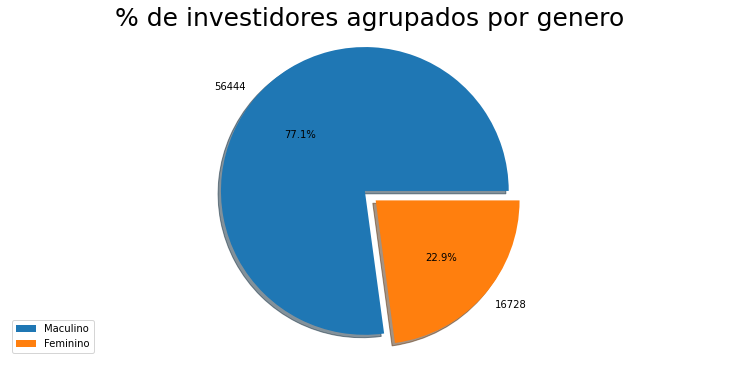

In [129]:
labels = pd_inv_genero['genero']
pd_investidor = pd_inv_genero['count']

# define o nível de separabilidade entre as partes, ordem do vetor representa as partes
explode = (0.1, 0)
plt.figure(figsize=(13,6))


plt.title('% de investidores agrupados por genero', fontsize=25)

# define o formato de visualização com saída em 1.1%%, sombras e a separação entre as partes
plt.pie(pd_investidor, labels=pd_investidor, autopct='%1.1f%%', shadow=True, explode=explode)

# inseri a legenda e a localização da legenda.
plt.legend(['Maculino', 'Feminino'], loc=3)

# define que o gráfico será plotado em circulo
plt.axis('equal')

plt.show()

## **Investimento por por profissão**

In [202]:
df_profissao_vlr_investido = df_join_inv_ope.groupBy("profissao").agg(sum("total_compra").alias("vlr_investido"))

pd_profissao = df_profissao_vlr_investido.orderBy('vlr_investido',ascending=False)

pd_profissao = pd_profissao.withColumn("vlr_investido", format_number("vlr_investido", 2))

In [147]:
pd_profissao = pd_profissao.toPandas().head(10)
pd_profissao

,profissao,vlr_investido
0,ENGENHEIRO,"184,223,607.78"
1,OUTROS,"151,826,258.91"
2,ADMINISTRADOR,"115,298,479.53"
3,MÉDICO,"93,032,312.96"
4,APOSENTADO (EXCETO FUNCIONÁRIO PÚBLICO),"84,328,260.54"
5,ANALISTA DE SISTEMAS,"69,105,722.35"
6,SERVIDOR PÚBLICO FEDERAL,"66,604,991.15"
7,EMPRESÁRIO,"53,584,427.97"
8,ADVOGADO,"44,969,835.86"
9,BANCARIO E ECONOMIÁRIO,"41,774,819.37"


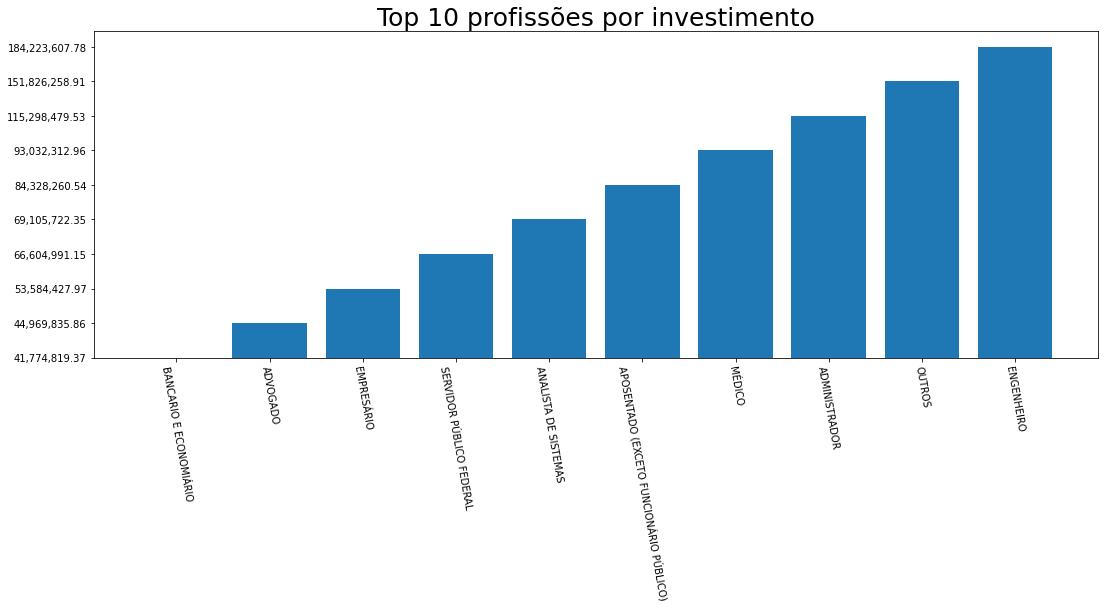

In [201]:
pd_profissao.sort_index(ascending=False, inplace=True)
top_10_profissoes = pd_profissao['profissao']
top_10_vlr_investido = pd_profissao['vlr_investido']


plt.figure(figsize=(18,6),)

plt.title('Top 10 profissões por investimento', fontsize=25)
plt.bar(top_10_profissoes, top_10_vlr_investido)

plt.xticks(rotation=-80)

plt.show()

## **Valor de investimento por estado civil**

In [240]:
 df_estado_civil = df_join_inv_ope.groupBy('estado_civil').agg(sum('total_compra').alias("vlr_investido"))

In [241]:
df_estado_civil = df_estado_civil.orderBy('vlr_investido',ascending=False)
df_estado_civil = df_estado_civil.withColumn("vlr_investido", format_number("vlr_investido", 2))
df_estado_civil.show(100)

+-------------+--------------+
| estado_civil| vlr_investido|
+-------------+--------------+
|       Casado|822,026,193.49|
|  Solteiro(a)|396,325,679.25|
|     Separado| 97,661,766.46|
|União estável| 46,592,092.28|
|     Viúvo(a)| 21,305,050.52|
+-------------+--------------+



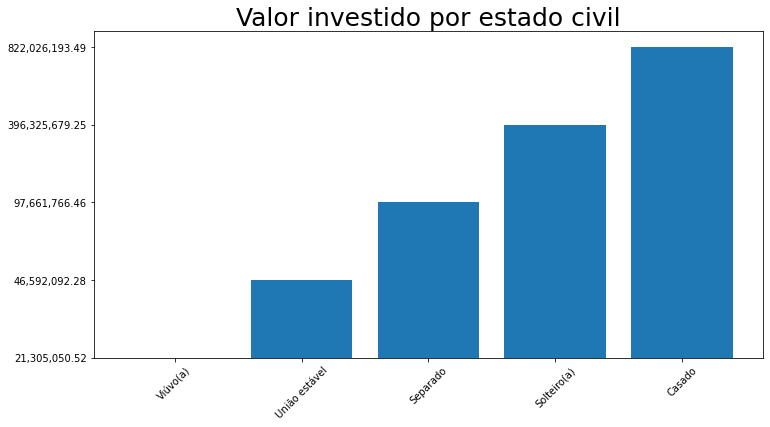

In [242]:
pd_estado_civil = df_estado_civil.toPandas()

pd_estado_civil.sort_index(ascending=False, inplace=True)
estado_civil = pd_estado_civil['estado_civil']
vlr_investido = pd_estado_civil['vlr_investido']


plt.figure(figsize=(12,6))

plt.title('Valor investido por estado civil', fontsize=25)
plt.bar(estado_civil , vlr_investido)

plt.xticks(rotation=45)

plt.show()